After cleaning and thorough exploration of the data set, we can move to find new features. And drop some unwanted columns that are not useful.

In [75]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, calendar
from collections import defaultdict
import plotly
import plotly.graph_objs as go
from sklearn import preprocessing
from sklearn import metrics

# ML models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# neural net
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras import optimizers

# setup 
plotly.offline.init_notebook_mode(connected=True)
#sns.set_style(style="whitegrid")
sns.set_style('ticks')
sns.set_palette('bright')

# display charts inline
%matplotlib inline

# to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [76]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Load previously cleaned train data

In [77]:
%%time
# load previously cleaned data
train_df = pd.read_csv('../data/extra_cols_train.csv',index_col=0)

<string>:2: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



CPU times: user 6.62 s, sys: 867 ms, total: 7.49 s
Wall time: 7.72 s


In [78]:
# X_train = pd.read_csv('../data/X_train.csv',index_col=0)
# X_test = pd.read_csv('../data/X_test.csv',index_col=0)
# y_train = pd.read_csv('../data/y_train.csv',index_col=0)
# y_test = pd.read_csv('../data/y_test.csv',index_col=0)

### What does the data look like?

In [79]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,revenue,year,month,day,weekday,hour,day_of_year
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,2,4,15,32
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,5,33
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,1,33
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,google + online,organic,Unknown,google,0.0,2016,9,3,5,5,33
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.0,2016,9,2,4,13,32


In [80]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899888 entries, 0 to 903652
Data columns (total 43 columns):
channelGrouping                                 899888 non-null object
date                                            899888 non-null int64
fullVisitorId                                   899888 non-null object
sessionId                                       899888 non-null object
visitId                                         899888 non-null int64
visitNumber                                     899888 non-null int64
visitStartTime                                  899888 non-null int64
device.browser                                  899888 non-null object
device.deviceCategory                           899888 non-null object
device.isMobile                                 899888 non-null bool
device.operatingSystem                          899888 non-null object
geoNetwork.city                                 899888 non-null object
geoNetwork.continent                       

In [81]:
features_train_df = train_df.copy()

In [82]:
# Let us remove columns that are not needed at all
cols_to_drop = []

# remove revenue because that was added just for better visualization purposes
cols_to_drop.append('revenue')

# id fields serve no purpose
cols_to_drop.append('fullVisitorId')
cols_to_drop.append('sessionId')
cols_to_drop.append('visitId')

# since we have data only for a year it is not useful
cols_to_drop.append('year')

# date is redundant because visitStartTime includes date
cols_to_drop.append('date')

# visitStartTime is broken into day, month etc. and exact time upto seconds doesn't make business sense
cols_to_drop.append('visitStartTime')

# continent is redundant becuase sub-continent is bit more granular but includes continent info
cols_to_drop.append('geoNetwork.continent')

# isMobile is redundant, device category already have that category
cols_to_drop.append('device.isMobile')

features_train_df.drop(cols_to_drop, axis=1, inplace=True)

In [83]:
checkpoint_1_df = features_train_df.copy()

In [84]:
features_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899888 entries, 0 to 903652
Data columns (total 34 columns):
channelGrouping                                 899888 non-null object
visitNumber                                     899888 non-null int64
device.browser                                  899888 non-null object
device.deviceCategory                           899888 non-null object
device.operatingSystem                          899888 non-null object
geoNetwork.city                                 899888 non-null object
geoNetwork.country                              899888 non-null object
geoNetwork.metro                                899888 non-null object
geoNetwork.networkDomain                        899888 non-null object
geoNetwork.region                               899888 non-null object
geoNetwork.subContinent                         899888 non-null object
totals.bounces                                  899888 non-null int64
totals.hits                            

In [85]:
# Handling the categorical data
# If some values of a categorical variable are less frequent than 5% than they all can be combined in one

In [86]:
all_cat_cols = list(features_train_df.select_dtypes(include='object').columns)
all_cat_cols

['channelGrouping',
 'device.browser',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.campaign',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source']

In [87]:
# reduces the levels for categorical variables
def reduce_category_levels(df, category_cols):
    ignored_cols = []
    mult_fact = 100/df.shape[0]
    for col in category_cols:
        unique_vals = df[col].nunique()
        print(col)
        print("\nnumber of unique values", unique_vals)
#         if unique_vals > 100:
#             print("Ignoring column", col, "\n")
#             ignored_cols.append(col)
#             continue
        
        val_percents = df[col].value_counts()*mult_fact
        dummy_val = ('dummy_'+str(col)).replace('.','_')
        print(dummy_val)
        
        values_to_be_replaced = []
        for val_percent in val_percents.iteritems():
            #print(val_percent[0], val_percent[1])
            if val_percent[1] < 1:
#                 df[col].replace(val_percent[0],dummy_val, inplace=True)
                values_to_be_replaced.append(val_percent[0])
        replace_idxs = df[df[col].isin(values_to_be_replaced)].index
#         print(len(replace_idxs))
#         print(df[df.index.isin(replace_idxs)].shape)
        df.loc[replace_idxs,col] = dummy_val
        print("reduced number of unique values", df[col].nunique())
        print("remaining of unique values", df[col].unique())

    return ignored_cols

In [88]:
ignored_cols = reduce_category_levels(features_train_df, all_cat_cols)

channelGrouping

number of unique values 8
dummy_channelGrouping
reduced number of unique values 7
remaining of unique values ['Organic Search' 'Referral' 'Paid Search' 'Affiliates' 'Direct'
 'dummy_channelGrouping' 'Social']
device.browser

number of unique values 53
dummy_device_browser
reduced number of unique values 6
remaining of unique values ['Chrome' 'Firefox' 'dummy_device_browser' 'Internet Explorer' 'Safari'
 'Edge']
device.deviceCategory

number of unique values 3
dummy_device_deviceCategory
reduced number of unique values 3
remaining of unique values ['desktop' 'mobile' 'tablet']
device.operatingSystem

number of unique values 20
dummy_device_operatingSystem
reduced number of unique values 7
remaining of unique values ['Windows' 'Macintosh' 'Linux' 'Android' 'iOS' 'Chrome OS'
 'dummy_device_operatingSystem']
geoNetwork.city

number of unique values 649
dummy_geoNetwork_city
reduced number of unique values 9
remaining of unique values ['dummy_geoNetwork_city' 'not available

In [89]:
ignored_cols

[]

In [90]:
unique_vals = [ (col, list(features_train_df[col].unique())) for col in all_cat_cols]

In [91]:
unique_vals = []
for col in all_cat_cols:
    uniques = list(features_train_df[col].unique())
    uniques.insert(0,col)
    unique_vals.append(uniques)

In [92]:
unique_vals

[['channelGrouping',
  'Organic Search',
  'Referral',
  'Paid Search',
  'Affiliates',
  'Direct',
  'dummy_channelGrouping',
  'Social'],
 ['device.browser',
  'Chrome',
  'Firefox',
  'dummy_device_browser',
  'Internet Explorer',
  'Safari',
  'Edge'],
 ['device.deviceCategory', 'desktop', 'mobile', 'tablet'],
 ['device.operatingSystem',
  'Windows',
  'Macintosh',
  'Linux',
  'Android',
  'iOS',
  'Chrome OS',
  'dummy_device_operatingSystem'],
 ['geoNetwork.city',
  'dummy_geoNetwork_city',
  'not available in demo dataset',
  '(not set)',
  'London',
  'Mountain View',
  'New York',
  'San Francisco',
  'Sunnyvale',
  'San Jose'],
 ['geoNetwork.country',
  'Turkey',
  'Australia',
  'Spain',
  'Indonesia',
  'United Kingdom',
  'Italy',
  'dummy_geoNetwork_country',
  'Netherlands',
  'India',
  'France',
  'Brazil',
  'Poland',
  'Germany',
  'Canada',
  'Thailand',
  'Taiwan',
  'Russia',
  'Philippines',
  'Mexico',
  'United States',
  'Japan',
  'Vietnam'],
 ['geoNetwork.m

In [93]:
import json
data = {}

for col in all_cat_cols:
    uniques = list(features_train_df[col].unique())
    data[col] = uniques
    
json_data = json.dumps(data)

In [94]:
json_data

'{"channelGrouping": ["Organic Search", "Referral", "Paid Search", "Affiliates", "Direct", "dummy_channelGrouping", "Social"], "device.browser": ["Chrome", "Firefox", "dummy_device_browser", "Internet Explorer", "Safari", "Edge"], "device.deviceCategory": ["desktop", "mobile", "tablet"], "device.operatingSystem": ["Windows", "Macintosh", "Linux", "Android", "iOS", "Chrome OS", "dummy_device_operatingSystem"], "geoNetwork.city": ["dummy_geoNetwork_city", "not available in demo dataset", "(not set)", "London", "Mountain View", "New York", "San Francisco", "Sunnyvale", "San Jose"], "geoNetwork.country": ["Turkey", "Australia", "Spain", "Indonesia", "United Kingdom", "Italy", "dummy_geoNetwork_country", "Netherlands", "India", "France", "Brazil", "Poland", "Germany", "Canada", "Thailand", "Taiwan", "Russia", "Philippines", "Mexico", "United States", "Japan", "Vietnam"], "geoNetwork.metro": ["(not set)", "not available in demo dataset", "London", "San Francisco-Oakland-San Jose CA", "New Yo

In [95]:
type(data)

dict

In [96]:
with open('../data/unique_cat_values.json', 'w', encoding='utf-8') as f:
     json.dump(data, f)

In [97]:
unique_vals_df = pd.DataFrame(unique_vals)

In [98]:
unique_vals_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,channelGrouping,Organic Search,Referral,Paid Search,Affiliates,Direct,dummy_channelGrouping,Social,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,device.browser,Chrome,Firefox,dummy_device_browser,Internet Explorer,Safari,Edge,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,device.deviceCategory,desktop,mobile,tablet,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,device.operatingSystem,Windows,Macintosh,Linux,Android,iOS,Chrome OS,dummy_device_operatingSystem,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,geoNetwork.city,dummy_geoNetwork_city,not available in demo dataset,(not set),London,Mountain View,New York,San Francisco,Sunnyvale,San Jose,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,trafficSource.campaign,(not set),AW - Dynamic Search Ads Whole Site,Data Share Promo,dummy_trafficSource_campaign,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
15,trafficSource.keyword,(not provided),dummy_trafficSource_keyword,Unknown,6qEhsCssdK0z36ri,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
16,trafficSource.medium,organic,referral,cpc,affiliate,(none),dummy_trafficSource_medium,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
17,trafficSource.referralPath,Unknown,/,dummy_trafficSource_referralPath,/analytics/web/,/yt/about/th/,/yt/about/ru/,/yt/about/,/yt/about/es-419/,/yt/about/tr/,/yt/about/vi/,/yt/about/pt-BR/,None,None,None,None,None,None,None,None,None,None,None


In [99]:
unique_vals_df.to_csv('../data/cat_unique_values.csv',sep='|')

In [100]:
# let us drop the ignored columns for now
features_train_df.drop(ignored_cols, inplace=True, axis=1)

In [101]:
features_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899888 entries, 0 to 903652
Data columns (total 34 columns):
channelGrouping                                 899888 non-null object
visitNumber                                     899888 non-null int64
device.browser                                  899888 non-null object
device.deviceCategory                           899888 non-null object
device.operatingSystem                          899888 non-null object
geoNetwork.city                                 899888 non-null object
geoNetwork.country                              899888 non-null object
geoNetwork.metro                                899888 non-null object
geoNetwork.networkDomain                        899888 non-null object
geoNetwork.region                               899888 non-null object
geoNetwork.subContinent                         899888 non-null object
totals.bounces                                  899888 non-null int64
totals.hits                            

In [102]:
features_train_df['geoNetwork.city'].unique()

array(['dummy_geoNetwork_city', 'not available in demo dataset',
       '(not set)', 'London', 'Mountain View', 'New York',
       'San Francisco', 'Sunnyvale', 'San Jose'], dtype=object)

In [103]:
checkpoint_2_df = features_train_df.copy()

In [104]:
# should do something about the month, day etc. those can be binned and then one hot encoded
# for month we can divided in 4 quarters
# day of month can be divided in start,mid,end
# weekday can be divided as weekday and weekend
# day of the year can be ignore for now
# hour can be ignore for now

# quarter
features_train_df['quarter'] = features_train_df['month'].apply(lambda x: 'quarter'+str(np.mod(x,4)))

In [105]:
# month star, mid, end
#features_train_df['month_period'] = features_train_df['weekday'].apply(lambda x: 'start' if x<6 else (if x>25 'mid' else 'end'))

In [106]:
features_train_df['week_day_end'] = features_train_df['weekday'].apply(lambda x: 'week_day' if x<5 else 'weekend')

In [107]:
# drop other date columns
# features_train_df.drop(['month','day','weekday','hour','day_of_year'], axis=1, inplace=True)
features_train_df.drop(['weekday','day_of_year'], axis=1, inplace=True)

In [108]:
features_train_df.shape

(899888, 34)

In [109]:
checkpoint_3_df = features_train_df.copy()

In [110]:
# one hot encode the categorical variables
# limit to categorical data using df.select_dtypes()
X_cat = features_train_df.select_dtypes(include=[object])
X_cat.columns

Index(['channelGrouping', 'device.browser', 'device.deviceCategory',
       'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'quarter',
       'week_day_end'],
      dtype='object')

In [111]:
X_cat.shape

(899888, 21)

In [112]:
features_train_df.select_dtypes(exclude=[object]).columns

Index(['visitNumber', 'totals.bounces', 'totals.hits', 'totals.newVisits',
       'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page', 'trafficSource.campaignCode',
       'trafficSource.isTrueDirect', 'month', 'day', 'hour'],
      dtype='object')

In [113]:
[col  for col in features_train_df.select_dtypes(exclude=[object]).columns if features_train_df[col].nunique()>2]

['visitNumber',
 'totals.hits',
 'totals.pageviews',
 'totals.transactionRevenue',
 'trafficSource.adwordsClickInfo.page',
 'month',
 'day',
 'hour']

In [114]:
category_columns = list(X_cat.columns)
category_columns.extend(['month','day','hour'])
category_columns

['channelGrouping',
 'device.browser',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.campaign',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source',
 'quarter',
 'week_day_end',
 'month',
 'day',
 'hour']

In [115]:
X = pd.get_dummies(features_train_df, columns=category_columns)

In [116]:
X.shape

(899888, 213)

In [117]:
X.head()

,visitNumber,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.campaignCode,trafficSource.isTrueDirect,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,channelGrouping_dummy_channelGrouping,device.browser_Chrome,device.browser_Edge,device.browser_Firefox,device.browser_Internet Explorer,device.browser_Safari,device.browser_dummy_device_browser,device.deviceCategory_desktop,device.deviceCategory_mobile,device.deviceCategory_tablet,device.operatingSystem_Android,device.operatingSystem_Chrome OS,device.operatingSystem_Linux,device.operatingSystem_Macintosh,device.operatingSystem_Windows,device.operatingSystem_dummy_device_operatingSystem,device.operatingSystem_iOS,geoNetwork.city_(not set),geoNetwork.city_London,geoNetwork.city_Mountain View,geoNetwork.city_New York,geoNetwork.city_San Francisco,geoNetwork.city_San Jose,geoNetwork.city_Sunnyvale,geoNetwork.city_dummy_geoNetwork_city,geoNetwork.city_not available in demo dataset,geoNetwork.country_Australia,geoNetwork.country_Brazil,geoNetwork.country_Canada,geoNetwork.country_France,geoNetwork.country_Germany,geoNetwork.country_India,geoNetwork.country_Indonesia,geoNetwork.country_Italy,geoNetwork.country_Japan,geoNetwork.country_Mexico,geoNetwork.country_Netherlands,geoNetwork.country_Philippines,geoNetwork.country_Poland,geoNetwork.country_Russia,geoNetwork.country_Spain,geoNetwork.country_Taiwan,geoNetwork.country_Thailand,geoNetwork.country_Turkey,geoNetwork.country_United Kingdom,geoNetwork.country_United States,geoNetwork.country_Vietnam,geoNetwork.country_dummy_geoNetwork_country,geoNetwork.metro_(not set),geoNetwork.metro_London,geoNetwork.metro_Los Angeles CA,geoNetwork.metro_New York NY,geoNetwork.metro_San Francisco-Oakland-San Jose CA,geoNetwork.metro_dummy_geoNetwork_metro,geoNetwork.metro_not available in demo dataset,geoNetwork.networkDomain_(not set),geoNetwork.networkDomain_comcast.net,geoNetwork.networkDomain_comcastbusiness.net,geoNetwork.networkDomain_dummy_geoNetwork_networkDomain,geoNetwork.networkDomain_rr.com,geoNetwork.networkDomain_ttnet.com.tr,geoNetwork.networkDomain_unknown.unknown,geoNetwork.networkDomain_verizon.net,geoNetwork.region_(not set),geoNetwork.region_California,geoNetwork.region_England,geoNetwork.region_New York,geoNetwork.region_dummy_geoNetwork_region,geoNetwork.region_not available in demo dataset,geoNetwork.subContinent_Australasia,geoNetwork.subContinent_Central America,geoNetwork.subContinent_Eastern Asia,geoNetwork.subContinent_Eastern Europe,geoNetwork.subContinent_Northern America,geoNetwork.subContinent_Northern Europe,geoNetwork.subContinent_South America,geoNetwork.subContinent_Southeast Asia,geoNetwork.subContinent_Southern Asia,geoNetwork.subContinent_Southern Europe,geoNetwork.subContinent_Western Asia,geoNetwork.subContinent_Western Europe,geoNetwork.subContinent_dummy_geoNetwork_subContinent,trafficSource.adContent_Others,trafficSource.adContent_dummy_trafficSource_adContent,trafficSource.adwordsClickInfo.adNetworkType_Google Search,trafficSource.adwordsClickInfo.adNetworkType_Unknown,trafficSource.adwordsClickInfo.adNetworkType_dummy_trafficSource_adwordsClickInfo_adNetworkType,trafficSource.adwordsClickInfo.gclId_Unknown,trafficSource.adwordsClickInfo.gclId_dummy_trafficSource_adwordsClickInfo_gclId,trafficSource.adwordsClickInfo.slot_Top,trafficSource.adwordsClickInfo.slot_Unknown,trafficSource.adwordsClickInfo.slot_dummy_trafficSource_adwordsClickInfo_slot,trafficSource.campaign_(not set),trafficSource.campaign_AW - Dynamic Search Ads Whole Site,trafficSource.campaign_Data Share Promo,trafficSource.campaign_dummy_trafficSource_campaign,trafficSource.keyword_(not provided),trafficSource.keyword_6qEhsCssdK0z36ri,trafficSource.keyword_Unknown,trafficSource.keyword_dummy_trafficSource_keyw

# create a LabelEncoder object and fit it to each feature in X

# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
X_2 = X_cat.apply(le.fit_transform)
X_2.head()

X_2['geoNetwork.subContinent'].value_counts()

X_2 = X_2[X_2['geoNetwork.subContinent'] == 4]

X_2.tail()

# create a OneHotEncoder object, and fit it to all of X

# 1. INSTANTIATE
enc = preprocessing.OneHotEncoder()

# 2. FIT
enc.fit(X_2)

# 3. Transform
X_onehotlabels = enc.transform(X_2).toarray()
X_onehotlabels.shape

# as can be seen, you've the same number of rows 891
# but now you've so many more columns due to how we changed all the categorical data into numerical data

X_onehotlabels

enc.feature_indices_

X_1 = features_train_df.select_dtypes(exclude=[object])

X_1.tail()

X_1.shape, X_1.index

X_1 = X_1[X_1.index.isin(X_2.index)]

# join the int and category columns
X = pd.concat([X_1,pd.DataFrame(X_onehotlabels,index=X_1.index)],axis=1)

X.shape

X.head()

In [33]:
# get train and test indices according to the dates
# last two months is test data

In [118]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,revenue,year,month,day,weekday,hour,day_of_year
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,2,4,15,32
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,5,33
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,1,33
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,google + online,organic,Unknown,google,0.0,2016,9,3,5,5,33
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.0,2016,9,2,4,13,32


In [119]:
train_df['date'].min(), train_df['date'].max()

(20160801, 20170801)

In [120]:
#train = train_df[(train_df['date']<20170601) & (train_df.index.isin(X_2.index))].index
train = train_df[train_df['date']<20170601].index

In [121]:
len(train)

762857

In [122]:
#test = train_df[(train_df['date']>=20170601) & (train_df.index.isin(X_2.index)) ].index
test = train_df[train_df['date']>=20170601].index

In [123]:
len(test)

137031

In [124]:
X_train = X.loc[train]

In [125]:
X_test = X.loc[test]

In [126]:
y_train = X_train['totals.transactionRevenue']
y_test = X_test['totals.transactionRevenue']

In [127]:
train_df.shape

(899888, 43)

In [128]:
y_train = np.log1p(y_train.values)
y_test = np.log1p(y_test.values)

# or

# y_train = y_train/10**6
# y_test = y_test/10**6


In [129]:
y_train.shape, y_test.shape

((762857,), (137031,))

In [130]:
X_train.drop('totals.transactionRevenue', axis=1, inplace=True)
X_test.drop('totals.transactionRevenue', axis=1, inplace=True)

In [131]:
X_train.shape, X_test.shape

((762857, 212), (137031, 212))

In [132]:
# X_train.describe()

In [133]:
# save it temporarily
# X_train.to_csv("../data/X_train.csv")

In [134]:
# X_test.to_csv("../data/X_test.csv")
# y_train.to_csv("../data/y_train.csv")
# y_test.to_csv("../data/y_test.csv")

In [135]:
# Start with Linear Regression

In [410]:
reg = LinearRegression(normalize=True)

In [411]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [412]:
reg.score(X_test,y_test)

-4.0333737517558165e+27

In [245]:
#svr = SVR()

In [246]:
#svr.fit(X_train,y_train)

In [136]:
import lightgbm as lgb

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [137]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((762857, 212), (762857,), (137031, 212), (137031,))

In [138]:
# model=LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=-1,learning_rate=0.01,n_estimators=1000,max_bin=255,subsample_for_bin=50000,
#               objective=None,min_split_gain=0,min_child_weight=3,min_child_samples=10,subsample=1,subsample_freq=1,colsample_bytree=1,
#               reg_alpha=0.1,reg_lambda=0,seed=17,silent=False,nthread=-1,n_jobs=-1)

In [139]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    #return pred_test_y, model, pred_val_y
    return model, pred_val_y

In [140]:
# Training the model #
model, pred_val = run_lgb(X_train, y_train, X_test, y_test)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.71793
[200]	valid_0's rmse: 1.7128
[300]	valid_0's rmse: 1.71159
[400]	valid_0's rmse: 1.71418
Early stopping, best iteration is:
[300]	valid_0's rmse: 1.71159


In [141]:
X_train.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            903643, 903644, 903645, 903646, 903647, 903648, 903649, 903650,
            903651, 903652],
           dtype='int64', length=762857)

In [142]:
features_train_df.columns

Index(['channelGrouping', 'visitNumber', 'device.browser',
       'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.campaignCode', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'month', 'day',
       'hour', 'quarter', 'week_day_end'],
      dtype='object')

In [143]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.campaignCode', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'revenue',

In [144]:
results_df = train_df[['fullVisitorId','totals.transactionRevenue']]

In [145]:
results_df.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            903643, 903644, 903645, 903646, 903647, 903648, 903649, 903650,
            903651, 903652],
           dtype='int64', length=899888)

In [146]:
results_df = results_df.loc[X_test.index]

In [147]:
results_df.shape

(137031, 2)

In [148]:
pred_val[pred_val<0] = 0

In [149]:
results_df['predicted_revenue'] = [np.expm1(rev) for rev in pred_val]

#or

#results_df['predicted_revenue'] = pred_val

# or

# results_df['predicted_revenue'] = pred_val*10**6

In [150]:
results_df.head()

,fullVisitorId,totals.transactionRevenue,predicted_revenue
4822,6136444193474843946,0.0,0.006474
4823,9499266297099251015,0.0,0.000000
4824,965275377736384905,0.0,0.028760
4825,4609130972135924274,0.0,0.002783
4826,7154533339220730030,0.0,0.000000


In [151]:
results_df = results_df.groupby("fullVisitorId")["totals.transactionRevenue", "predicted_revenue"].sum().reset_index()

In [152]:
results_df[results_df['totals.transactionRevenue'] > 0].sort_values(['totals.transactionRevenue'],ascending=False)

,fullVisitorId,totals.transactionRevenue,predicted_revenue
98837,9417857471295131045,1.517012e+10,10066.722471
2533,79204932396995037,7.047150e+09,115.269532
29550,1957458976293878100,6.709380e+09,273.409361
95099,9026840718082010040,6.423130e+09,3491.978561
54229,4604965471651937146,4.280700e+09,844.151828
...,...,...,...
80614,7447137895250670218,1.500000e+06,157.169041
59797,5201418842615044194,1.500000e+06,1.640171
110612,9213584705844626996,1.200000e+06,821.600649
96898,9213584705844626996,1.200000e+06,166.526181


In [153]:
print(np.sqrt(metrics.mean_squared_error(np.log1p(\
        results_df["totals.transactionRevenue"].values), np.log1p(results_df["predicted_revenue"].values))))

1.7490810637388126


In [154]:
# optional
print(np.sqrt(metrics.mean_squared_error(\
        results_df["totals.transactionRevenue"].values, results_df["predicted_revenue"].values)))

68803827.52409507


In [155]:
# test out if we predict 0 revenue ....just for testing purposes
results_df["zero_predicted"] = 0

In [156]:
print(np.sqrt(metrics.mean_squared_error(np.log1p(\
        results_df["totals.transactionRevenue"].values), np.log1p(results_df["zero_predicted"].values))))

2.2866025325494768


In [157]:
diff = np.sort(np.absolute(results_df['totals.transactionRevenue']-results_df['predicted_revenue']))

In [158]:
diff = [item for item in diff if item >10000]

In [159]:
diff[0:100]

[10028.977163771096,
 10176.564828021454,
 10230.5728085973,
 10353.781120824262,
 10558.321349464895,
 10613.86545267324,
 10649.066663104702,
 11274.449471699769,
 11296.459826272598,
 11587.740571059569,
 11879.69792517116,
 12132.344006452615,
 12278.46464156801,
 12377.694415858075,
 12588.351018934283,
 13138.601581721652,
 13150.05495179801,
 14062.955515495692,
 14619.27156477381,
 14661.23814463986,
 14749.69477874815,
 14779.145577005489,
 16087.687165947536,
 16196.293495716985,
 16366.159065959133,
 16383.472220166095,
 16396.877924948094,
 16418.894224571548,
 16688.868171069935,
 16969.654201855425,
 17511.02047728989,
 17727.63823242862,
 17795.474305167205,
 17956.40351109491,
 19090.51611981499,
 20222.24747145967,
 20316.667748634198,
 20367.967938096273,
 20569.899807722708,
 20693.65623293941,
 20978.714847002317,
 21034.972477932813,
 21195.508919122534,
 21673.702983722054,
 22629.177179077065,
 22836.566833221517,
 23725.402857108555,
 24814.771501879302,
 24966.

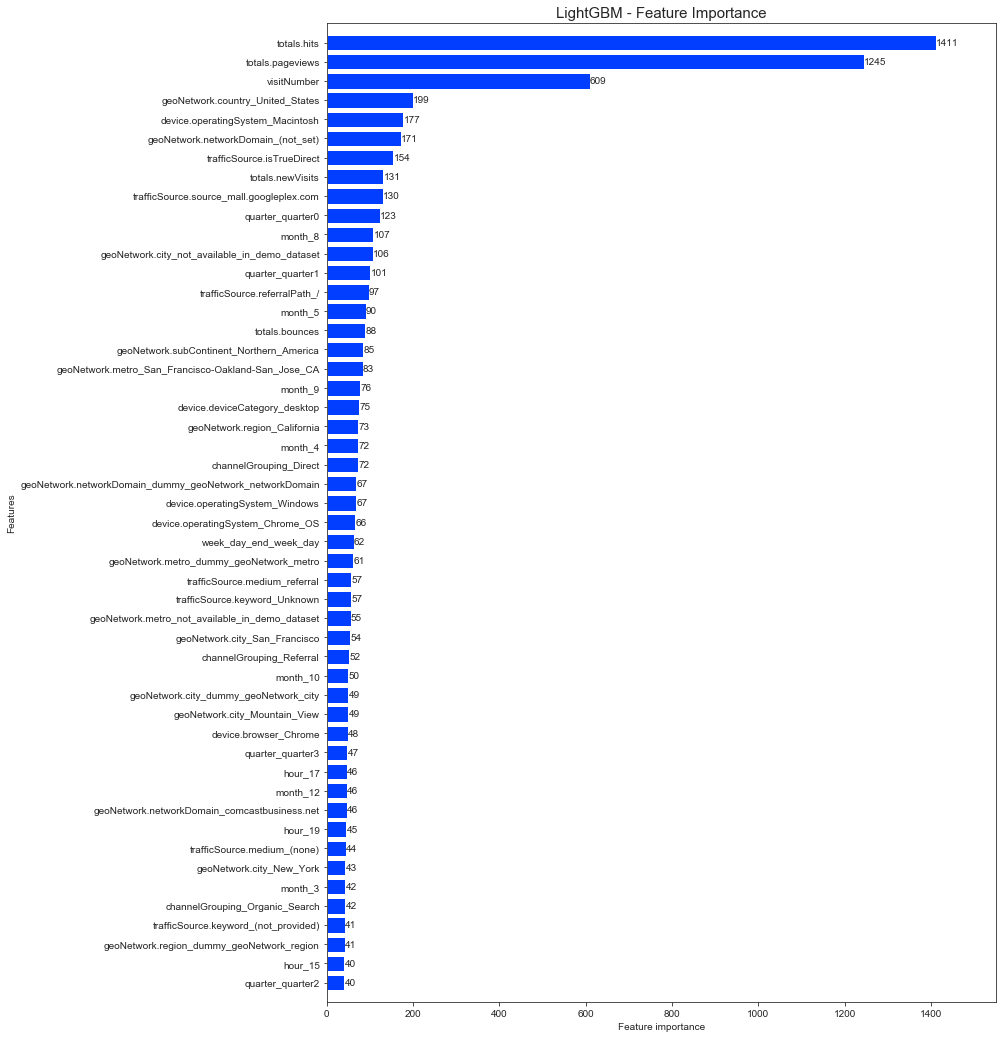

In [160]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

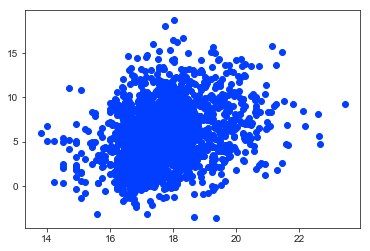

In [161]:
plt.scatter(results_df['totals.transactionRevenue'].apply(np.log), results_df['predicted_revenue'].apply(np.log))

In [162]:
np.log1p(results_df['totals.transactionRevenue']).describe()

count    111119.000000
mean          0.293390
std           2.267712
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.442594
Name: totals.transactionRevenue, dtype: float64

#### Testing on Future data

In [273]:
X_future = pd.read_csv('../data/X_future.csv', index_col=0, dtype={'fullVisitorId':np.str})

In [274]:
X_future['fullVisitorId'].nunique()

617242

In [275]:
X_future.head()

,fullVisitorId,visitNumber,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.isTrueDirect,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,channelGrouping_dummy_channelGrouping,device.browser_Chrome,device.browser_Edge,device.browser_Firefox,device.browser_Internet Explorer,device.browser_Safari,device.browser_dummy_device_browser,device.deviceCategory_desktop,device.deviceCategory_mobile,device.deviceCategory_tablet,device.operatingSystem_Android,device.operatingSystem_Chrome OS,device.operatingSystem_Linux,device.operatingSystem_Macintosh,device.operatingSystem_Windows,device.operatingSystem_dummy_device_operatingSystem,device.operatingSystem_iOS,geoNetwork.city_(not set),geoNetwork.city_London,geoNetwork.city_Mountain View,geoNetwork.city_New York,geoNetwork.city_San Francisco,geoNetwork.city_San Jose,geoNetwork.city_Sunnyvale,geoNetwork.city_dummy_geoNetwork_city,geoNetwork.city_not available in demo dataset,geoNetwork.country_Australia,geoNetwork.country_Brazil,geoNetwork.country_Canada,geoNetwork.country_France,geoNetwork.country_Germany,geoNetwork.country_India,geoNetwork.country_Indonesia,geoNetwork.country_Italy,geoNetwork.country_Japan,geoNetwork.country_Mexico,geoNetwork.country_Netherlands,geoNetwork.country_Philippines,geoNetwork.country_Poland,geoNetwork.country_Russia,geoNetwork.country_Spain,geoNetwork.country_Taiwan,geoNetwork.country_Thailand,geoNetwork.country_Turkey,geoNetwork.country_United Kingdom,geoNetwork.country_United States,geoNetwork.country_Vietnam,geoNetwork.country_dummy_geoNetwork_country,geoNetwork.metro_(not set),geoNetwork.metro_London,geoNetwork.metro_Los Angeles CA,geoNetwork.metro_New York NY,geoNetwork.metro_San Francisco-Oakland-San Jose CA,geoNetwork.metro_dummy_geoNetwork_metro,geoNetwork.metro_not available in demo dataset,geoNetwork.networkDomain_(not set),geoNetwork.networkDomain_comcast.net,geoNetwork.networkDomain_comcastbusiness.net,geoNetwork.networkDomain_dummy_geoNetwork_networkDomain,geoNetwork.networkDomain_rr.com,geoNetwork.networkDomain_ttnet.com.tr,geoNetwork.networkDomain_unknown.unknown,geoNetwork.networkDomain_verizon.net,geoNetwork.region_(not set),geoNetwork.region_California,geoNetwork.region_England,geoNetwork.region_New York,geoNetwork.region_dummy_geoNetwork_region,geoNetwork.region_not available in demo dataset,geoNetwork.subContinent_Australasia,geoNetwork.subContinent_Central America,geoNetwork.subContinent_Eastern Asia,geoNetwork.subContinent_Eastern Europe,geoNetwork.subContinent_Northern America,geoNetwork.subContinent_Northern Europe,geoNetwork.subContinent_South America,geoNetwork.subContinent_Southeast Asia,geoNetwork.subContinent_Southern Asia,geoNetwork.subContinent_Southern Europe,geoNetwork.subContinent_Western Asia,geoNetwork.subContinent_Western Europe,geoNetwork.subContinent_dummy_geoNetwork_subContinent,trafficSource.adContent_Others,trafficSource.adContent_dummy_trafficSource_adContent,trafficSource.adwordsClickInfo.adNetworkType_Google Search,trafficSource.adwordsClickInfo.adNetworkType_Unknown,trafficSource.adwordsClickInfo.adNetworkType_dummy_trafficSource_adwordsClickInfo_adNetworkType,trafficSource.adwordsClickInfo.gclId_Unknown,trafficSource.adwordsClickInfo.gclId_dummy_trafficSource_adwordsClickInfo_gclId,trafficSource.adwordsClickInfo.slot_Top,trafficSource.adwordsClickInfo.slot_Unknown,trafficSource.adwordsClickInfo.slot_dummy_trafficSource_adwordsClickInfo_slot,trafficSource.campaign_(not set),trafficSource.campaign_AW - Dynamic Search Ads Whole Site,trafficSource.campaign_Data Share Promo,trafficSource.campaign_dummy_trafficSource_campaign,trafficSource.keyword_(not provided),trafficSource.keyword_6qEhsCssdK0z36ri,trafficSource.keyword_Unknown,trafficSource.keyword_dummy_trafficSource_keyword,trafficSource.medium_(none),traffic

In [276]:
checkpoint_4_df = X_future.copy()

In [277]:
X_future = checkpoint_4_df.copy()

In [278]:
X_future.shape, X_train.shape

((804684, 208), (762857, 212))

In [279]:
diff_cols = list(set(X_train.columns) - set(X_future.columns))

In [280]:
for col in diff_cols:
    X_future[col] = 0

In [281]:
model.predict(X_train)

array([ 0.00320659, -0.0031863 , -0.00268547, ...,  0.08219694,
        0.09142121,  0.98715848])

In [282]:
X_future_visitor = X_future['fullVisitorId']

In [283]:
X_future.drop(['fullVisitorId'], axis=1, inplace=True)

In [284]:
y_future = model.predict(X_future)

In [285]:
y_future

array([-0.13911628, -0.04694498, -0.08461778, ..., -1.61173956,
        0.86123551, -1.46171624])

In [286]:
y_future[y_future<0] = 0

In [287]:
X_future_visitor

0         6167871330617112363
1         0643697640977915618
2         6059383810968229466
3         2376720078563423631
4         2314544520795440038
                 ...         
804679    9084225574121020383
804680    6146210385566305056
804681    7484543584006767361
804682    2915966035609674201
804683    5334918847827785763
Name: fullVisitorId, Length: 804684, dtype: object

In [288]:
X_future_visitor.nunique()

617242

In [289]:
future_results_df = pd.DataFrame(X_future_visitor)

In [290]:
future_results_df['predicted_revenue'] = [np.expm1(rev) for rev in y_future]

In [291]:
future_results_df

,fullVisitorId,predicted_revenue
0,6167871330617112363,0.000000
1,0643697640977915618,0.000000
2,6059383810968229466,0.000000
3,2376720078563423631,0.000000
4,2314544520795440038,0.000036
...,...,...
804679,9084225574121020383,8.145243
804680,6146210385566305056,0.000000
804681,7484543584006767361,0.000000
804682,2915966035609674201,1.366082


In [251]:
#future_results_df['fullVisitorId'] = future_results_df['fullVisitorId'].astype(np.str)

In [257]:
#future_results_df['fullVisitorId'] = future_results_df['fullVisitorId'].apply(lambda x: x.zfill(19))

In [292]:
submission_df = future_results_df.groupby("fullVisitorId")["predicted_revenue"].sum().reset_index()

In [296]:
submission_df['predicted_revenue'] = np.log1p(submission_df['predicted_revenue'])

In [297]:
submission_df

,fullVisitorId,predicted_revenue
0,0000000259678714014,0.000000
1,0000049363351866189,0.066942
2,0000053049821714864,0.000000
3,0000059488412965267,0.225508
4,0000085840370633780,0.000000
...,...,...
617237,9999905960465191827,0.018584
617238,9999941518946450908,0.184867
617239,9999969142283897422,0.000000
617240,9999985820452794361,0.083363


In [298]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617242 entries, 0 to 617241
Data columns (total 2 columns):
fullVisitorId        617242 non-null object
predicted_revenue    617242 non-null float64
dtypes: float64(1), object(1)
memory usage: 9.4+ MB


In [261]:
#submission_df['fullVisitorId'] = submission_df['fullVisitorId'].astype(np.str)

In [262]:
#submission_df['fullVisitorId'] = submission_df['fullVisitorId'].apply(lambda x: x.zfill(19))

In [299]:
submission_df.to_csv('../data/submission.csv',header=['fullVisitorId','PredictedLogRevenue'],index=None)

In [447]:
numeric_cols = ['visitNumber', 'totals.hits', 'totals.pageviews', 'trafficSource.adwordsClickInfo.page']

In [487]:
# Normalize using Min-Max scaling
scaler = preprocessing.MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [492]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.0003

model = Sequential()
model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1))

adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)

In [493]:
print('Dataset size: %s' % X_train.shape[0])
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % X_train.shape[1])
print('Features used: %s' % X_train.columns.values)

Dataset size: 762857
Epochs: 10
Learning rate: 0.0003
Batch size: 64
Input dimension: 212
Features used: ['visitNumber' 'totals.bounces' 'totals.hits' 'totals.newVisits'
 'totals.pageviews' 'trafficSource.adwordsClickInfo.isVideoAd'
 'trafficSource.adwordsClickInfo.page' 'trafficSource.campaignCode'
 'trafficSource.isTrueDirect' 'channelGrouping_Affiliates'
 'channelGrouping_Direct' 'channelGrouping_Organic Search'
 'channelGrouping_Paid Search' 'channelGrouping_Referral'
 'channelGrouping_Social' 'channelGrouping_dummy_channelGrouping'
 'device.browser_Chrome' 'device.browser_Edge' 'device.browser_Firefox'
 'device.browser_Internet Explorer' 'device.browser_Safari'
 'device.browser_dummy_device_browser' 'device.deviceCategory_desktop'
 'device.deviceCategory_mobile' 'device.deviceCategory_tablet'
 'device.operatingSystem_Android' 'device.operatingSystem_Chrome OS'
 'device.operatingSystem_Linux' 'device.operatingSystem_Macintosh'
 'device.operatingSystem_Windows'
 'device.operatingSys

In [494]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               54528     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 87,553
Trainable params: 87,553
Non-trainable params: 0
_________________________________________________________________


In [495]:
%%time
history = model.fit(x=X_train.values, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(X_test.values, y_test))

Train on 762857 samples, validate on 137031 samples
Epoch 1/10
762857/762857 [==============================] - 32s 43us/step - loss: 3.2054 - val_loss: 3.5788
Epoch 2/10
762857/762857 [==============================] - 32s 42us/step - loss: 2.8805 - val_loss: 3.5563
Epoch 3/10
762857/762857 [==============================] - 33s 43us/step - loss: 2.7931 - val_loss: 3.2988
Epoch 4/10
762857/762857 [==============================] - 33s 43us/step - loss: 2.7427 - val_loss: 3.2153
Epoch 5/10
762857/762857 [==============================] - 32s 42us/step - loss: 2.7028 - val_loss: 3.5838
Epoch 6/10
762857/762857 [==============================] - 32s 42us/step - loss: 2.6600 - val_loss: 3.4346
Epoch 7/10
762857/762857 [==============================] - 32s 43us/step - loss: 2.6099 - val_loss: 3.3268
Epoch 8/10
762857/762857 [==============================] - 33s 43us/step - loss: 2.5639 - val_loss: 3.2599
Epoch 9/10
762857/762857 [==============================] - 33s 43us/step - loss: 2.

In [519]:
pred_val = model.predict(X_test)

In [527]:
pred_val = pred_val.flatten()

In [529]:
pred_val[pred_val<0] = 0

In [538]:
mse = metrics.mean_squared_error(pred_val, y_test)
rmse = np.sqrt(mse)
mse, rmse

(3.4034562169673888, 1.8448458518172701)

In [530]:
results_df['predicted_revenue'] = [np.expm1(rev) for rev in pred_val]

#or

#results_df['predicted_revenue'] = pred_val

# or

# results_df['predicted_revenue'] = pred_val*10**6

In [531]:
results_df.head()

,fullVisitorId,totals.transactionRevenue,predicted_revenue
4822,6136444193474843946,0.0,0.0
4823,9499266297099251015,0.0,0.0
4824,965275377736384905,0.0,0.0
4825,4609130972135924274,0.0,0.0
4826,7154533339220730030,0.0,0.0


In [532]:
results_df = results_df.groupby("fullVisitorId")["totals.transactionRevenue", "predicted_revenue"].sum().reset_index()

In [533]:
results_df[results_df['totals.transactionRevenue'] > 0].sort_values(['totals.transactionRevenue'],ascending=False)

,fullVisitorId,totals.transactionRevenue,predicted_revenue
98837,9417857471295131045,1.517012e+10,442083.855165
2533,79204932396995037,7.047150e+09,13.191463
29550,1957458976293878100,6.709380e+09,41.972765
95099,9026840718082010040,6.423130e+09,2059.452039
54229,4604965471651937146,4.280700e+09,108.371964
...,...,...,...
80614,7447137895250670218,1.500000e+06,560.232124
59797,5201418842615044194,1.500000e+06,0.000000
110612,9213584705844626996,1.200000e+06,11.325359
96898,9213584705844626996,1.200000e+06,4.015071


In [534]:
results_df

,fullVisitorId,totals.transactionRevenue,predicted_revenue
0,26722803385797,0.0,0.000000
1,48421062322244,0.0,0.000000
2,62267706107999,0.0,0.000000
3,62349695125717,0.0,0.000000
4,64767209884626,0.0,0.000000
...,...,...,...
111114,999156736475815013,0.0,0.000000
111115,9992851597599268755,0.0,0.000000
111116,9995936593177786964,0.0,0.028155
111117,9999773079368714197,0.0,0.000000


In [535]:
print(np.sqrt(metrics.mean_squared_error(np.log1p(\
        results_df["totals.transactionRevenue"].values), np.log1p(results_df["predicted_revenue"].values))))

1.8946303252666068


In [142]:
X_train.head()

,visitNumber,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.campaignCode,trafficSource.isTrueDirect,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,channelGrouping_dummy_channelGrouping,device.browser_Chrome,device.browser_Edge,device.browser_Firefox,device.browser_Internet Explorer,device.browser_Safari,device.browser_dummy_device_browser,device.deviceCategory_desktop,device.deviceCategory_mobile,device.deviceCategory_tablet,device.operatingSystem_Android,device.operatingSystem_Chrome OS,device.operatingSystem_Linux,device.operatingSystem_Macintosh,device.operatingSystem_Windows,device.operatingSystem_dummy_device_operatingSystem,device.operatingSystem_iOS,geoNetwork.city_(not set),geoNetwork.city_London,geoNetwork.city_Mountain View,geoNetwork.city_New York,geoNetwork.city_San Francisco,geoNetwork.city_San Jose,geoNetwork.city_Sunnyvale,geoNetwork.city_dummy_geoNetwork_city,geoNetwork.city_not available in demo dataset,geoNetwork.country_Australia,geoNetwork.country_Brazil,geoNetwork.country_Canada,geoNetwork.country_France,geoNetwork.country_Germany,geoNetwork.country_India,geoNetwork.country_Indonesia,geoNetwork.country_Italy,geoNetwork.country_Japan,geoNetwork.country_Mexico,geoNetwork.country_Netherlands,geoNetwork.country_Philippines,geoNetwork.country_Poland,geoNetwork.country_Russia,geoNetwork.country_Spain,geoNetwork.country_Taiwan,geoNetwork.country_Thailand,geoNetwork.country_Turkey,geoNetwork.country_United Kingdom,geoNetwork.country_United States,geoNetwork.country_Vietnam,geoNetwork.country_dummy_geoNetwork_country,geoNetwork.metro_(not set),geoNetwork.metro_London,geoNetwork.metro_Los Angeles CA,geoNetwork.metro_New York NY,geoNetwork.metro_San Francisco-Oakland-San Jose CA,geoNetwork.metro_dummy_geoNetwork_metro,geoNetwork.metro_not available in demo dataset,geoNetwork.networkDomain_(not set),geoNetwork.networkDomain_comcast.net,geoNetwork.networkDomain_comcastbusiness.net,geoNetwork.networkDomain_dummy_geoNetwork_networkDomain,geoNetwork.networkDomain_rr.com,geoNetwork.networkDomain_ttnet.com.tr,geoNetwork.networkDomain_unknown.unknown,geoNetwork.networkDomain_verizon.net,geoNetwork.region_(not set),geoNetwork.region_California,geoNetwork.region_England,geoNetwork.region_New York,geoNetwork.region_dummy_geoNetwork_region,geoNetwork.region_not available in demo dataset,geoNetwork.subContinent_Australasia,geoNetwork.subContinent_Central America,geoNetwork.subContinent_Eastern Asia,geoNetwork.subContinent_Eastern Europe,geoNetwork.subContinent_Northern America,geoNetwork.subContinent_Northern Europe,geoNetwork.subContinent_South America,geoNetwork.subContinent_Southeast Asia,geoNetwork.subContinent_Southern Asia,geoNetwork.subContinent_Southern Europe,geoNetwork.subContinent_Western Asia,geoNetwork.subContinent_Western Europe,geoNetwork.subContinent_dummy_geoNetwork_subContinent,trafficSource.adContent_Others,trafficSource.adContent_dummy_trafficSource_adContent,trafficSource.adwordsClickInfo.adNetworkType_Google Search,trafficSource.adwordsClickInfo.adNetworkType_Unknown,trafficSource.adwordsClickInfo.adNetworkType_dummy_trafficSource_adwordsClickInfo_adNetworkType,trafficSource.adwordsClickInfo.gclId_Unknown,trafficSource.adwordsClickInfo.gclId_dummy_trafficSource_adwordsClickInfo_gclId,trafficSource.adwordsClickInfo.slot_Top,trafficSource.adwordsClickInfo.slot_Unknown,trafficSource.adwordsClickInfo.slot_dummy_trafficSource_adwordsClickInfo_slot,trafficSource.campaign_(not set),trafficSource.campaign_AW - Dynamic Search Ads Whole Site,trafficSource.campaign_Data Share Promo,trafficSource.campaign_dummy_trafficSource_campaign,trafficSource.keyword_(not provided),trafficSource.keyword_6qEhsCssdK0z36ri,trafficSource.keyword_Unknown,trafficSource.keyword_dummy_trafficSource_keyword,trafficSource.medium_(

In [91]:
X_train.describe()

,visitNumber,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.campaignCode,trafficSource.isTrueDirect,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,channelGrouping_dummy_channelGrouping,device.browser_Chrome,device.browser_Edge,device.browser_Firefox,device.browser_Internet Explorer,device.browser_Safari,device.browser_dummy_device_browser,device.deviceCategory_desktop,device.deviceCategory_mobile,device.deviceCategory_tablet,device.operatingSystem_Android,device.operatingSystem_Chrome OS,device.operatingSystem_Linux,device.operatingSystem_Macintosh,device.operatingSystem_Windows,device.operatingSystem_dummy_device_operatingSystem,device.operatingSystem_iOS,geoNetwork.city_(not set),geoNetwork.city_London,geoNetwork.city_Mountain View,geoNetwork.city_New York,geoNetwork.city_San Francisco,geoNetwork.city_San Jose,geoNetwork.city_Sunnyvale,geoNetwork.city_dummy_geoNetwork_city,geoNetwork.city_not available in demo dataset,geoNetwork.country_Australia,geoNetwork.country_Brazil,geoNetwork.country_Canada,geoNetwork.country_France,geoNetwork.country_Germany,geoNetwork.country_India,geoNetwork.country_Indonesia,geoNetwork.country_Italy,geoNetwork.country_Japan,geoNetwork.country_Mexico,geoNetwork.country_Netherlands,geoNetwork.country_Philippines,geoNetwork.country_Poland,geoNetwork.country_Russia,geoNetwork.country_Spain,geoNetwork.country_Taiwan,geoNetwork.country_Thailand,geoNetwork.country_Turkey,geoNetwork.country_United Kingdom,geoNetwork.country_United States,geoNetwork.country_Vietnam,geoNetwork.country_dummy_geoNetwork_country,geoNetwork.metro_(not set),geoNetwork.metro_London,geoNetwork.metro_Los Angeles CA,geoNetwork.metro_New York NY,geoNetwork.metro_San Francisco-Oakland-San Jose CA,geoNetwork.metro_dummy_geoNetwork_metro,geoNetwork.metro_not available in demo dataset,geoNetwork.networkDomain_(not set),geoNetwork.networkDomain_comcast.net,geoNetwork.networkDomain_comcastbusiness.net,geoNetwork.networkDomain_dummy_geoNetwork_networkDomain,geoNetwork.networkDomain_rr.com,geoNetwork.networkDomain_ttnet.com.tr,geoNetwork.networkDomain_unknown.unknown,geoNetwork.networkDomain_verizon.net,geoNetwork.region_(not set),geoNetwork.region_California,geoNetwork.region_England,geoNetwork.region_New York,geoNetwork.region_dummy_geoNetwork_region,geoNetwork.region_not available in demo dataset,geoNetwork.subContinent_Australasia,geoNetwork.subContinent_Central America,geoNetwork.subContinent_Eastern Asia,geoNetwork.subContinent_Eastern Europe,geoNetwork.subContinent_Northern America,geoNetwork.subContinent_Northern Europe,geoNetwork.subContinent_South America,geoNetwork.subContinent_Southeast Asia,geoNetwork.subContinent_Southern Asia,geoNetwork.subContinent_Southern Europe,geoNetwork.subContinent_Western Asia,geoNetwork.subContinent_Western Europe,geoNetwork.subContinent_dummy_geoNetwork_subContinent,trafficSource.adContent_Others,trafficSource.adContent_dummy_trafficSource_adContent,trafficSource.adwordsClickInfo.adNetworkType_Google Search,trafficSource.adwordsClickInfo.adNetworkType_Unknown,trafficSource.adwordsClickInfo.adNetworkType_dummy_trafficSource_adwordsClickInfo_adNetworkType,trafficSource.adwordsClickInfo.gclId_Unknown,trafficSource.adwordsClickInfo.gclId_dummy_trafficSource_adwordsClickInfo_gclId,trafficSource.adwordsClickInfo.slot_Top,trafficSource.adwordsClickInfo.slot_Unknown,trafficSource.adwordsClickInfo.slot_dummy_trafficSource_adwordsClickInfo_slot,trafficSource.campaign_(not set),trafficSource.campaign_AW - Dynamic Search Ads Whole Site,trafficSource.campaign_Data Share Promo,trafficSource.campaign_dummy_trafficSource_campaign,trafficSource.keyword_(not provided),trafficSource.keyword_6qEhsCssdK0z36ri,trafficSource.keyword_Unknown,trafficSource.keyword_dummy_trafficSource_keyword,trafficSource.medium_(

In [102]:
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) 

In [103]:
X_test_scaled = scaler.transform(X_test)

In [104]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(X_train_scaled)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])

In [105]:
principalComponents.shape

(762857, 212)

In [106]:
print(X_train.dtypes)

visitNumber         int64
totals.bounces      int64
totals.hits         int64
totals.newVisits    int64
totals.pageviews    int64
                    ...  
hour_19             uint8
hour_20             uint8
hour_21             uint8
hour_22             uint8
hour_23             uint8
Length: 212, dtype: object


In [107]:
pca.explained_variance_ratio_

array([1.29332501e-01, 8.82679297e-02, 7.11319776e-02, 5.05282585e-02,
       4.07115845e-02, 2.83156592e-02, 2.67646154e-02, 2.55868861e-02,
       2.45580468e-02, 2.30092870e-02, 2.24521057e-02, 2.12250451e-02,
       1.84917696e-02, 1.68005757e-02, 1.57700133e-02, 1.47585269e-02,
       1.32995154e-02, 1.11894422e-02, 1.06289313e-02, 8.98784717e-03,
       8.57852930e-03, 8.06585793e-03, 7.93361541e-03, 7.54910639e-03,
       7.44498533e-03, 7.25189473e-03, 7.01918658e-03, 6.93297595e-03,
       6.63267271e-03, 6.56782661e-03, 6.18169574e-03, 6.07790667e-03,
       5.92554510e-03, 5.46311610e-03, 5.05947004e-03, 4.62863679e-03,
       4.56311555e-03, 4.14769163e-03, 4.13353316e-03, 4.05983066e-03,
       4.03462779e-03, 3.93868669e-03, 3.88382865e-03, 3.83666886e-03,
       3.80529887e-03, 3.65361449e-03, 3.57365272e-03, 3.51765324e-03,
       3.38886846e-03, 3.32205620e-03, 3.28653886e-03, 3.19478611e-03,
       3.08769852e-03, 2.97157229e-03, 2.91990388e-03, 2.86967400e-03,
      

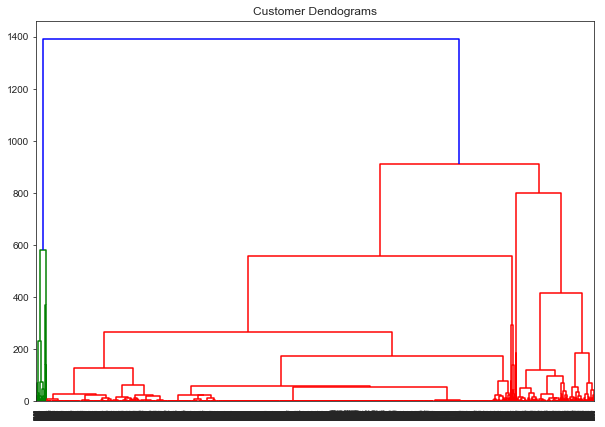

In [54]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(principalComponents[0:10000,0:2], method='ward'))  

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(principalComponents[0:10000,0:25]) 

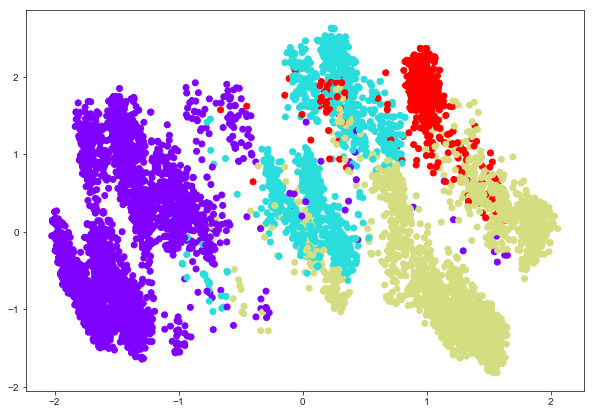

In [132]:
plt.figure(figsize=(10, 7))  
plt.scatter(principalComponents[0:10000,0], principalComponents[0:10000,1], c=cluster.labels_, cmap='rainbow')  

In [56]:
# Training the model #
#model, pred_val = run_lgb(X_train, y_train, X_test, y_test)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.71793
[200]	valid_0's rmse: 1.7128
[300]	valid_0's rmse: 1.71159
[400]	valid_0's rmse: 1.71418
Early stopping, best iteration is:
[300]	valid_0's rmse: 1.71159


In [123]:
pca_train = principalComponents[:,0:100]

In [124]:
pca_train.shape

(762857, 100)

In [125]:
pca_test = pca.transform(X_test_scaled)

In [126]:
pca_test = pca_test[:,0:100]

In [127]:
pca_test.shape

(137031, 100)

In [128]:
model, pred_val = run_lgb(pca_train, y_train, pca_test, y_test)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.05642
[200]	valid_0's rmse: 2.05671
Early stopping, best iteration is:
[114]	valid_0's rmse: 2.05606


In [ ]:
# linear regression for pca comp

In [1]:
reg = LinearRegression()

NameError: name 'LinearRegression' is not defined

In [87]:
reg.fit(pca_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [88]:
reg.score(pca_test, y_test)

0.19429417101008573

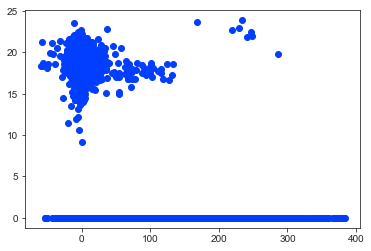

In [90]:
plt.scatter(pca_train[:,1],y_train)